# Transient CSEM for a layered, marine model

Same as `1D-Model.ipynb`, but with to small extent in $x$ and $y$ directions.

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Name is used to store the data for each frequency.
name = '1D-Model-wrong-x-y'

In [2]:
%matplotlib notebook

## Model and Survey

In [3]:
src = [0, 0, -180]
rec = [np.array([3000, 5000, 7000]), np.zeros(3), -200]
res = np.array([1e10, 1/3, 1, 50, 1])
depth = np.array([0, -200, -2200, -2300])

Here we create a dummy mesh with one cell in x- and y-directions, and our 1D model in z-direction. From this, we can interpolate the model to our varying meshes afterwards.

<IPython.core.display.Javascript object>


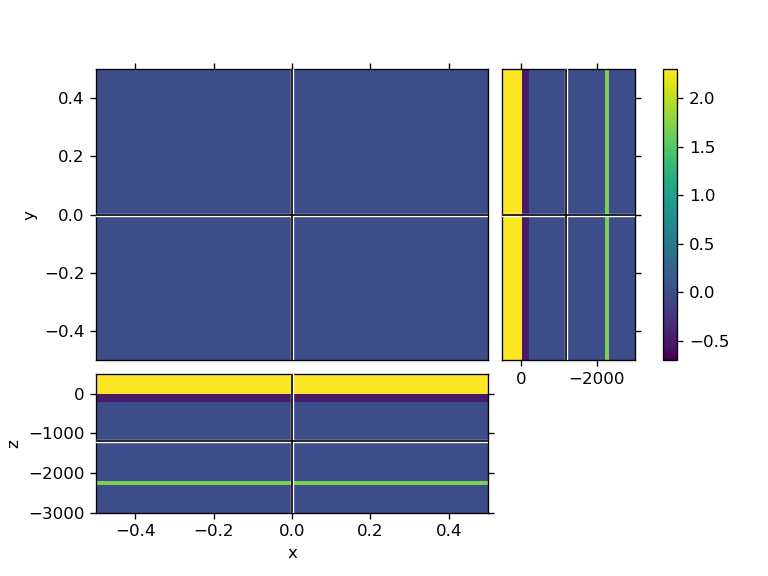

In [4]:
# Create the mesh.
orig_mesh = emg3d.TensorMesh(
    [[1,], [1,], np.r_[1000, -np.diff(depth)[::-1], 1000]],
    x0=('C', 'C', depth[-1]-1000))

# Create a resistivity model using the 1D model and the above mesh.
orig_model = emg3d.Model(orig_mesh, property_x=np.array(res)[::-1], mapping='Resistivity')

# QC.
orig_mesh.plot_3d_slicer(np.log10(orig_model.property_x), zlim=[-3000, 500], clim=np.log10([0.2, 200]))

## Fourier Transform parameters

We only compute frequencies $0.007 < f < 32$ Hz, which yields enough precision for our purpose.

This means, instead of 35 frequencies from 0.00002 - 126 Hz, we only need 19 frequencies from 0.008 - 32 Hz.

In [5]:
# Define desired times.
time = np.logspace(-2, 2, 301)

# Initiate a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=time,
    fmin=0.007,
    fmax=32,
    ft='fftlog',  # Fourier transform to use
    ftarg={'pts_per_dec': 5, 'add_dec': [-2, 1], 'q': 0},
)

# Dense frequencies for comparison reasons
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()/2), np.log10(Fourier.freq_req.max()*2), 301)

   time        [s] :  0.01 - 100 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  2.00364E-05 - 126.421 : 35  [min-max; #]
   Calc. freq [Hz] :  0.00797664 - 31.7556 : 19  [min-max; #]


## Frequency-domain computation

In [6]:
# Automatic gridding settings.
grid_opts = {
    'center': (src[0], src[1], rec[2]), 
    'domain': [[-100, 7100], [-400, 400], [-2300, 0]],
    'properties': [0.3, 1, 1, 1e5],  # <= Difference to original NB: [0.3, 1e5, 1, 1e5]
    'min_width_limits': 100,
    'max_buffer': 50000,
    'seasurface': 0.0,
    'lambda_from_center': True
}
    
# Initiate data array and log dict.
data = np.zeros(Fourier.freq_calc.size, dtype=complex)
log = {}

# Loop over frequencies, going from high to low.
for fi, freq in enumerate(Fourier.freq_calc[::-1]):
    print(f"  {fi+1:2}/{Fourier.freq_calc.size} :: {freq:10.6f} Hz", end='\r')
    
    # Key is used to store the data etc.
    key = int(freq*1e6)

    # Construct mesh and model.
    grid = emg3d.meshes.construct_mesh(frequency=freq, **grid_opts)
    model = orig_model.interpolate2grid(orig_mesh, grid)
    # grid.plot_3d_slicer(np.log10(model.property_x), zlim=[-3000, 500], clim=np.log10([0.2, 200]))  # QC

    # Solve the system.
    sfield = emg3d.fields.get_source_field(
        grid, [src[0], src[1], src[2], 0, 0], freq, strength=0)
    efield, info = emg3d.solve(
        grid, model, sfield, verb=-1,
        return_info=True, tol=1e-6/freq,  # f-dep. tolerance
        sslsolver=True, semicoarsening=True, linerelaxation=True,
    )
    
    data = emg3d.fields.get_receiver(grid, efield.fx, (rec[0], rec[1], rec[2]))

    # Store some info in the log.   
    log[str(int(freq*1e6))] = {
        'freq': freq,
        'nC': grid.nC,
        'stretching': max(np.r_[grid.hx[1:]/grid.hx[:-1], grid.hx[:-1]/grid.hx[1:],
                                grid.hy[1:]/grid.hy[:-1], grid.hy[:-1]/grid.hy[1:],
                                grid.hz[1:]/grid.hz[:-1], grid.hz[:-1]/grid.hz[1:]]),
        'dminmax': [np.min(np.r_[grid.hx, grid.hy, grid.hz]),
                    np.max(np.r_[grid.hx, grid.hy, grid.hz])],
        'info': info,
        'data': data,
    }

:: emg3d :: 2.0e-09; 1(3); 0:00:02; CONVERGED
:: emg3d :: 1.0e-08; 1(3); 0:00:02; CONVERGED
:: emg3d :: 7.3e-08; 1(3); 0:00:02; CONVERGED
:: emg3d :: 7.7e-08; 1(4); 0:00:03; CONVERGED
:: emg3d :: 2.8e-09; 1(6); 0:00:04; CONVERGED
:: emg3d :: 4.4e-09; 1(6); 0:00:06; CONVERGED
:: emg3d :: 3.5e-08; 1(6); 0:00:06; CONVERGED
:: emg3d :: 3.8e-07; 1(6); 0:00:07; CONVERGED
:: emg3d :: 8.1e-07; 2(7); 0:00:08; CONVERGED
:: emg3d :: 6.7e-07; 2(8); 0:00:12; CONVERGED
:: emg3d :: 2.1e-06; 2(9); 0:00:14; CONVERGED
:: emg3d :: 2.0e-06; 2(11); 0:00:16; CONVERGED
:: emg3d :: 5.7e-06; 2(10); 0:00:19; CONVERGED
:: emg3d :: 7.8e-06; 2(11); 0:00:21; CONVERGED
:: emg3d :: 1.8e-05; 2(12); 0:00:23; CONVERGED
:: emg3d :: 1.8e-05; 3(13); 0:00:25; CONVERGED
:: emg3d :: 3.7e-05; 3(13); 0:00:25; CONVERGED
:: emg3d :: 3.7e-05; 3(14); 0:00:27; CONVERGED
:: emg3d :: 6.8e-05; 3(14); 0:00:27; CONVERGED


### Store data

In [7]:
emg3d.save('../data/'+name+'.h5', log=log)
log = emg3d.load('../data/'+name+'.h5')['log']

Data saved to «/home/dtr/Codes/article-TDEM/data/1D-Model-wrong-x-y.h5»
[emg3d v0.14.3 (format 0.13.0) on 2020-11-26T13:55:55.877306].
Data loaded from «/home/dtr/Codes/article-TDEM/data/1D-Model-wrong-x-y.h5»
[emg3d v0.14.3 (format 0.13.0) on 2020-11-26T13:55:55.877306].


In [8]:
runtime = 0
for freq in Fourier.freq_calc[::-1]:
    key = int(freq*1e6)
    value = log[str(key)]
    print(f"  {value['freq']:7.3f} Hz: {value['info']['it_mg']:2g}/{value['info']['it_ssl']:g} it; "
          f"{value['info']['time']:4.0f} s; "
          f"max_a: {value['stretching']:.2f}; "
          f"nC: {value['nC']:8,.0f}; "
          f"h: {value['dminmax'][0]:5.0f} / {value['dminmax'][1]:7.0f}")
    runtime += value['info']['time']
    
print(f"\n                **** TOTAL RUNTIME :: {runtime//60:.0f} min {runtime%60:.1f} s ****\n")

   31.756 Hz:  3/1 it;    2 s; max_a: 1.36; nC:   51,200; h:   100 /   13697
   20.036 Hz:  3/1 it;    2 s; max_a: 1.36; nC:   51,200; h:   100 /   13697
   12.642 Hz:  3/1 it;    2 s; max_a: 1.36; nC:   51,200; h:   100 /   13697
    7.977 Hz:  4/1 it;    3 s; max_a: 1.37; nC:   51,200; h:   100 /   13697
    5.033 Hz:  6/1 it;    4 s; max_a: 1.50; nC:   51,200; h:   100 /   16484
    3.176 Hz:  6/1 it;    6 s; max_a: 1.48; nC:   76,800; h:   100 /   16346
    2.004 Hz:  6/1 it;    6 s; max_a: 1.49; nC:   76,800; h:   100 /   17841
    1.264 Hz:  6/1 it;    7 s; max_a: 1.35; nC:   92,160; h:   100 /   12909
    0.798 Hz:  7/2 it;    8 s; max_a: 1.42; nC:   92,160; h:   100 /   16956
    0.503 Hz:  8/2 it;   12 s; max_a: 1.38; nC:  110,592; h:   100 /   12749
    0.318 Hz:  9/2 it;   14 s; max_a: 1.43; nC:  110,592; h:   100 /   13697
    0.200 Hz: 11/2 it;   16 s; max_a: 1.49; nC:  110,592; h:   100 /   17301
    0.126 Hz: 10/2 it;   19 s; max_a: 1.40; nC:  147,456; h:   100 /   15557

### Load data, interpolate at receiver location

In [9]:
# Initiate data with zeros.
data = np.zeros((Fourier.freq_calc.size, rec[0].size), dtype=complex)

# Loop over frequencies.
for fi, freq in enumerate(Fourier.freq_calc):
    key = int(freq*1e6)
    data[fi, :] = log[str(key)]['data']

### Interpolate missing frequencies and compute analytical result

In [10]:
data_int = np.zeros((Fourier.freq_req.size, rec[0].size), dtype=complex)

for fi in range(rec[0].size):
    data_int[:, fi] = Fourier.interpolate(data[:, fi])

# Compute analytical result using empymod
epm_req = empymod.dipole(src, rec, depth, res, Fourier.freq_req, verb=1)
epm_calc = empymod.dipole(src, rec, depth, res, Fourier.freq_calc, verb=1)
epm_dense = empymod.dipole(src, rec, depth, res, freq_dense, verb=1)

# Compute error
err =  np.clip(100*abs((data_int.imag-epm_req.imag)/epm_req.imag), 0.1, 100)

## Fourier Transform

Carry-out Fourier transform, compute analytical result

In [11]:
data_time = np.zeros((Fourier.time.size, rec[0].size))

# Compute corresponding time-domain signal.
for fi in range(rec[0].size):
    data_time[:, fi] = Fourier.freq2time(data[:, fi], rec[0][fi])

# Analytical result
epm_time = empymod.dipole(src, rec, depth, res, time, signal=0, verb=1)

# Relative error and peak error
err_egd = np.clip(100*abs((data_time-epm_time)/epm_time), 0.1, 100)

### Plot it

<IPython.core.display.Javascript object>


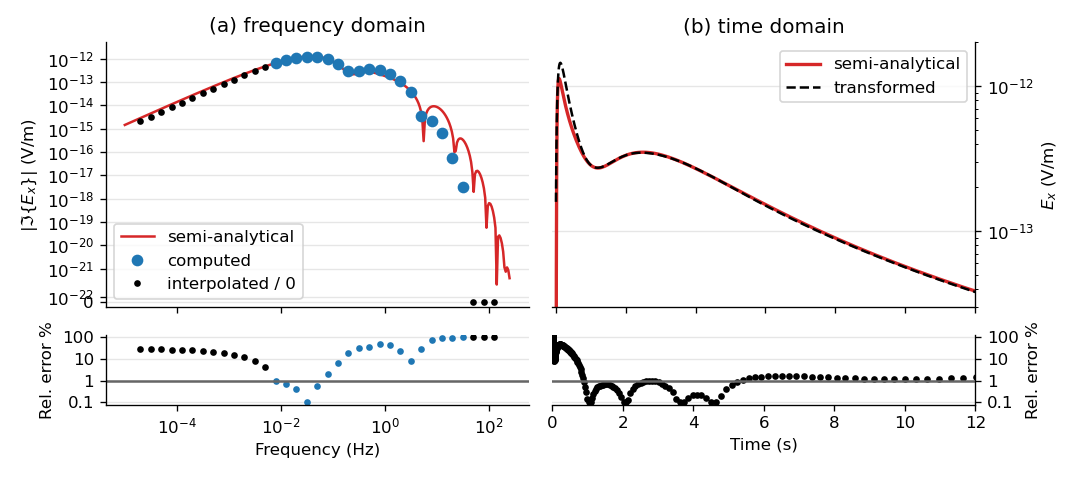

In [12]:
plt.figure(figsize=(9, 4))

ii = 1

# Imaginary, log-symlog
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) frequency domain')
plt.plot(freq_dense, abs(epm_dense[:, ii].imag), 'C3', label='semi-analytical')
plt.plot(Fourier.freq_calc, abs(data[:, ii].imag), 'C0o', label='computed')
plt.plot(Fourier.freq_req[~Fourier.freq_calc_i],
         abs(data_int[~Fourier.freq_calc_i, ii].imag), 'k.', label='interpolated / 0')
plt.ylabel('$|\Im\{E_x\}|$ (V/m)')
plt.xscale('log')
#plt.xlim([0.00001, 22])
plt.yscale('symlog', linthresh=5e-22)
plt.ylim([-1e-22, 5e-12])
ax1.set_xticklabels([])
plt.legend()
plt.grid(axis='y', c='0.9')

# Imaginary, error
ax2 = plt.subplot2grid((4, 2), (3, 0))
plt.plot(Fourier.freq_req[~Fourier.freq_calc_i], err[~Fourier.freq_calc_i, ii], 'k.')
plt.plot(Fourier.freq_calc, err[Fourier.freq_calc_i, ii], 'C0.')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Rel. error %')
plt.xlim(ax1.get_xlim())
plt.ylim([8e-2, 120])
plt.yticks([0.1, 1, 10, 100], ('0.1', '1', '10', '100'))
plt.grid(axis='y', c='0.9')


# Time domain
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3)
plt.title('(b) time domain')
plt.plot(time, epm_time[:, ii], 'C3', lw=2, label='semi-analytical')
plt.plot(time, data_time[:, ii], 'k--', label='transformed')
plt.xlim([-0.1, 12])
plt.ylim([3e-14, 2e-12])
plt.ylabel('$E_x$ (V/m)')
#plt.xscale('log')
plt.yscale('log')
ax3.set_xticklabels([])
plt.legend()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Time domain, error
ax4 = plt.subplot2grid((4, 2), (3, 1))
plt.plot(time, err_egd[:, ii], 'k.')
plt.axhline(1, color='.4')

plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.xlim([0, 12])
plt.ylim([8e-2, 120])
plt.yticks([0.1, 1, 10, 100], ('0.1', '1', '10', '100'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('../figures/08-marine-wrong-x-y.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


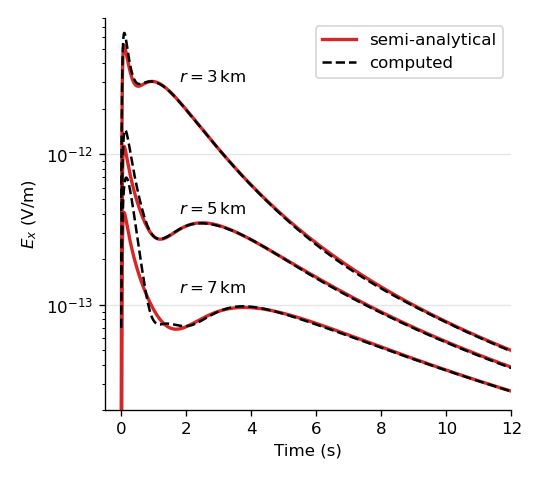

In [13]:
plt.figure(figsize=(4.5, 4))
ax = plt.gca()

# Time domain
lines = plt.plot(time, epm_time, 'C3', lw=2, label='semi-analytical')
plt.setp(lines[1:], label="_")
lines = plt.plot(time, data_time, 'k--', label='computed')
lines = plt.setp(lines[1:], label="_")
plt.xlim([-0.5, 12])
plt.ylim([2e-14, 8e-12])
plt.ylabel('$E_x$ (V/m)')
plt.yscale('log')
plt.xlabel('Time (s)')
plt.legend()
plt.text(1.8, 3e-12, f"$r={rec[0][0]/1000:1.0f}\,$km")
plt.text(1.8, 4e-13, f"$r={rec[0][1]/1000:1.0f}\,$km")
plt.text(1.8, 1.2e-13, f"$r={rec[0][2]/1000:1.0f}\,$km")

plt.grid(axis='y', c='0.9')

# Switch off spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Nov 26 13:55:58 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05)
  [GCC 7.5.0]

             numpy : 1.19.4
             scipy : 1.5.3
             numba : 0.51.2
             emg3d : 0.14.3
           empymod : 2.0.3
        discretize : 0.5.1
              h5py : 3.1.0
        matplotlib : 3.3.3
              tqdm : 4.53.0
           IPython : 7.19.0

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------